### Recortando Imagens para Serem Rotuladas

In [2]:
from PIL import Image
import os

caminho = '/content/drive/MyDrive'

os.chdir(caminho)

def fragment_and_save_image(image_path, rows, cols, output_dir):

    # Listar arquivos na pasta
    archives = os.listdir(image_path)

    # Listar arquivos recortados
    archive_list = []

    # Abrir a pasta
    for n, archive in enumerate(archives):

        jpg = image_path + '/' + archive

        # Abrir a imagem
        image = Image.open(jpg)
        width, height = image.size

        # Calcular o tamanho de cada fragmento
        fragment_width = width // cols
        fragment_height = height // rows

        # Criar o diretório de saída se não existir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for i in range(rows):
            for j in range(cols):
                left = j * fragment_width
                upper = i * fragment_height
                right = (j + 1) * fragment_width
                lower = (i + 1) * fragment_height

                # Definindo número do recorte:
                n_r = os.listdir(f'{image_path}/')[n].split('.')[0]

                # Recortar o fragmento
                fragment = image.crop((left, upper, right, lower))

                # Adicionar arquivo recortado à lista
                archive_list.append(f'fragment_{n_r}_{i}_{j}.jpg')

                # Salvar o fragmento como arquivo PNG
                fragment_path = os.path.join(output_dir, f'fragment_{n_r}_{i}_{j}.jpg')
                fragment.save(fragment_path)

    return archive_list

In [3]:
if len(os.listdir('/content/drive/MyDrive/Outros/recorts')) > 1000:
    archives = os.listdir('/content/drive/MyDrive/Outros/recorts')

else:
    archives = fragment_and_save_image('/content/drive/MyDrive/Outros/images', 15,
                                       15, '/content/drive/MyDrive/Outros/recorts')

### Gráfico de Comparação

In [4]:
import cv2
import matplotlib.pyplot as plt

def graph(resized_image, title_1,
          green_mask, title_2,
          green_areas, title_3):

    # Visualizar a imagem segmentada e as áreas verdes

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(green_mask, cmap='gray')
    plt.title(title_2)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(green_areas, cv2.COLOR_BGR2RGB))
    plt.title(title_3)
    plt.axis('off')

    plt.show()

### Separação de Áreas Verdes

In [5]:
import numpy as np

def green_area(link):

    # Carregar a imagem
    image = cv2.imread(link)

    # Redimensionar a imagem para aceleração do processamento
    scale_percent = 50  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # Converter a imagem para o espaço de cor HSV
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Definir intervalo de cor verde (na escala HSV)
    lower_green = np.array([30, 25, 25])
    upper_green = np.array([100, 255, 255])

    # Criar máscara para os pixels verdes
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Aplicar a máscara na imagem original
    green_areas = cv2.bitwise_and(resized_image, resized_image, mask=green_mask)

    return resized_image, green_mask, green_areas

### Porcentagem das Áreas Verdes

In [6]:
def perc_green_area(green_areas):

    # Converter a imagem para RGB (apenas para visualização no matplotlib)
    image_rgb = cv2.cvtColor(green_areas, cv2.COLOR_BGR2RGB)

    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(green_areas, cv2.COLOR_BGR2GRAY)

    # Aplicar um limiar para detectar pixels pretos
    # Pixels pretos serão aqueles com valor 0 no limiar binário
    _, black_and_white_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY_INV)

    # Contar o número de pixels pretos
    num_black_pixels = np.sum(black_and_white_image == 255)
    total_pixels = black_and_white_image.size

    # Calcular a porcentagem de pixels pretos
    percentage_black = (num_black_pixels / total_pixels) * 100

    return image_rgb, gray_image, black_and_white_image, percentage_black

### Teste das Funções

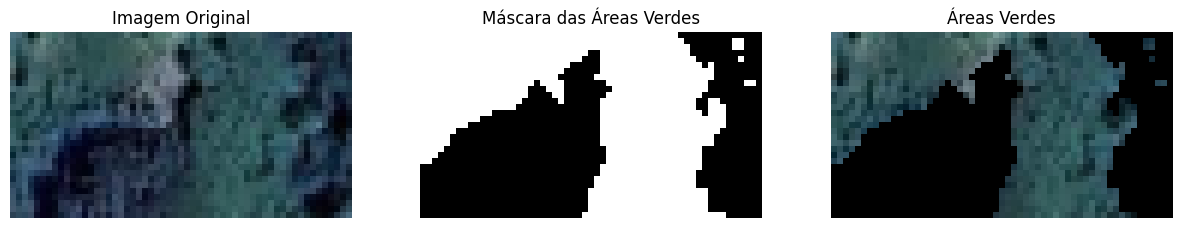

In [7]:
folder = '/content/drive/MyDrive/Outros/recorts/'

ir, gm, ga = green_area(f'{folder}fragment_9_14_14.jpg')

graph(ir, 'Imagem Original',
      gm, 'Máscara das Áreas Verdes',
      ga, 'Áreas Verdes')


O percentual de áreas verdes é de 52.74%



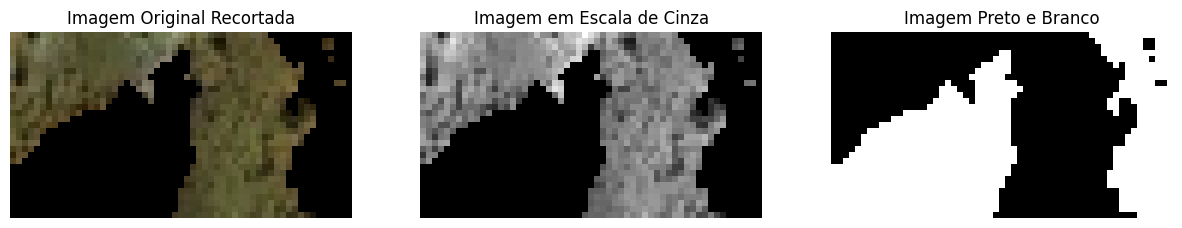

In [8]:
ic, gi, bwi, pb = perc_green_area(ga)

print(f'\nO percentual de áreas verdes é de {100 - pb:.2f}%\n')

graph(ic,  'Imagem Original Recortada',
      gi,  'Imagem em Escala de Cinza',
      bwi, 'Imagem Preto e Branco')

### Rotulando Imagens

In [9]:
import pandas as pd

data = []

for n, arch in enumerate(archives):

    ir, _, ga = green_area(f'{folder}{arch}')

    ic, _, _, pb = perc_green_area(ga)

    data.append({
        'Arquivo': arch,
        'Área total': ir,
        'Área verde': ic,
        'Percentual de verde': (100 - pb)
    })

# Criar o DataFrame
df = pd.DataFrame(data)

# Exportando CSV do DataFrame
df.to_csv('test.csv', index=False)

# Visualização de DataFrame
df.head()

,Arquivo,Área total,Área verde,Percentual de verde
0,fragment_66_8_5.jpg,"[[[87, 103, 104], [89, 103, 110], [84, 97, 113...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",73.548387
1,fragment_66_8_6.jpg,"[[[33, 76, 33], [28, 71, 28], [29, 72, 29], [2...","[[[33, 76, 33], [28, 71, 28], [29, 72, 29], [2...",99.290323
2,fragment_66_8_7.jpg,"[[[42, 76, 58], [41, 77, 56], [40, 76, 53], [3...","[[[58, 76, 42], [56, 77, 41], [53, 76, 40], [4...",90.387097
3,fragment_66_8_8.jpg,"[[[15, 41, 18], [17, 43, 20], [30, 56, 33], [3...","[[[18, 41, 15], [20, 43, 17], [33, 56, 30], [4...",96.064516
4,fragment_66_8_9.jpg,"[[[11, 37, 14], [12, 38, 15], [10, 36, 13], [1...","[[[14, 37, 11], [15, 38, 12], [13, 36, 10], [1...",92.193548


### Realizando predição de percentual de áreas verdes

##### Configurando dados

In [10]:
# Definindo DataFrame para predizer porcentagens
df_per = df[['Área total', 'Percentual de verde']]

# Embaralhando linhas
df_per = df_per.sample(frac=1, random_state=7).reset_index(drop=True)

# Separando dados de treino
df_train = df_per[:5000]

# Separando dados de teste
df_test = df_per[5000:5500]

# Visualizando dados de treino
df_train.head()

,Área total,Percentual de verde
0,"[[[57, 65, 24], [71, 79, 38], [82, 90, 50], [7...",68.647425
1,"[[[219, 220, 251], [160, 163, 203], [138, 144,...",1.697793
2,"[[[18, 38, 30], [34, 56, 53], [48, 69, 75], [1...",15.419355
3,"[[[129, 131, 155], [68, 70, 98], [55, 58, 89],...",2.516129
4,"[[[101, 123, 186], [97, 119, 180], [97, 118, 1...",2.516129


In [11]:
# Definir a dimensão desejada para as imagens
desired_size = (128, 128)  # Exemplo: 128x128 pixels

def resize_image(image_array, desired_size):
    image = Image.fromarray(np.uint8(image_array))
    image = image.resize(desired_size, Image.LANCZOS)
    return np.array(image)

# Extrair e redimensionar imagens
images = np.array([resize_image(np.array(img), desired_size) for img in df_train['Área total']])
labels = np.array(df_train['Percentual de verde'].tolist())

# Normalização das imagens (valores de pixels entre 0 e 1)
images = images / 255.0

# Normalização dos rótulos (escala entre 0 e 1)
labels = labels / 100.0

##### Arquitetura do modelo e treinamento dos dados

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Construção do modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(desired_size[0], desired_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Saída para regressão
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)

# Avaliação do modelo
loss = model.evaluate(X_val, y_val)
print(f'\nValidation Loss: {loss}')

Epoch 1/10
125/125 [==============================] - 142s 1s/step - loss: 0.1124 - val_loss: 0.0036
Epoch 2/10
125/125 [==============================] - 144s 1s/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/10
125/125 [==============================] - 141s 1s/step - loss: 0.0014 - val_loss: 0.0025
Epoch 4/10
125/125 [==============================] - 135s 1s/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/10
125/125 [==============================] - 139s 1s/step - loss: 0.0011 - val_loss: 0.0026
Epoch 6/10
125/125 [==============================] - 143s 1s/step - loss: 8.4655e-04 - val_loss: 0.0015
Epoch 7/10
125/125 [==============================] - 140s 1s/step - loss: 8.2888e-04 - val_loss: 9.5911e-04
Epoch 8/10
125/125 [==============================] - 142s 1s/step - loss: 9.8855e-04 - val_loss: 0.0015
Epoch 9/10
125/125 [==============================] - 140s 1s/step - loss: 6.9833e-04 - val_loss: 0.0025
Epoch 10/10
32/32 [==============================] - 10s 305ms/step - l

##### Predição dos dados de teste

In [ ]:
# Extraindo imagens teste e fazendo normalização
images_test = np.array([resize_image(np.array(img), desired_size) for img in df_test['Área total']])
images_test = images_test / 255.0

# Extraindo percentuais teste
labels_test = np.array(df_test['Percentual de verde'].tolist())

# Predizendo e revertendo a normalização das porcentagens
predictions = model.predict(images_test)
predictions = predictions * 100

##### Avaliação de acurácia do modelo

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular o erro absoluto médio (Mean Absolute Error - MAE)
mae = mean_absolute_error(labels_test, predictions)
print(f'MAE : {mae:.4f}')

# Calcular o erro quadrático médio (Mean Squared Error - MSE)
mse = mean_squared_error(labels_test, predictions)
print(f'MSE : {mse:.4f}')

# Calcular a raiz do erro quadrático médio (Root Mean Squared Error - RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.4f}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(labels_test, predictions)
print(f'R²  : {r2:.4f}')

#### Resultado final do percentual real e predito

In [44]:
pd.DataFrame({'Real': labels_test,
              'Predição': predictions.flatten()}).head()

,Real,Predição
0,54.612337,57.448067
1,34.012450,38.047962
2,96.151669,94.048653
3,74.759479,73.938629
4,6.734578,8.071768


### Realizando predição de áreas verdes

##### Configurando dados

In [57]:
# Definindo DataFrame para predizer porcentagens
df_av = df[['Área total', 'Área verde']]

# Definir a cor verde específica (RGB)
green_color = [0, 255, 0]

# Função para alterar os pixels não pretos para a cor verde
def apply_green_color(image_array, green_color):

    # Criar uma máscara onde os pixels não são pretos (0, 0, 0)
    mask = (image_array != [0, 0, 0]).any(axis=-1)

    # Aplicar a cor verde aos pixels que não são pretos
    image_array[mask] = green_color

    return image_array

# Aplicar a função a cada imagem na coluna "Área verde". A função para alterar os pixels
# não pretos de forma que se tornem um único tipo de verde servirá para ajudar ao modelo
# na predição dos locais considerados áreas verdes, visto que ele só precisará destingui
# r entre duas cores, e não todo o espectro de cores que engloba as áreas verdes.
df_av.loc[:, 'Área verde'] = df_av['Área verde'].apply(lambda x: apply_green_color(np.array(x), green_color))

In [58]:
# Embaralhando linhas
df_av = df_av.sample(frac=1, random_state=7).reset_index(drop=True)

# Separando dados de treino
df_train_av = df_av[:2000]

# Separando dados de teste
df_test_av = df_av[2000:2500]

# Visualizando dados de treino
df_train_av.head()

,Área total,Área verde
0,"[[[57, 65, 24], [71, 79, 38], [82, 90, 50], [7...","[[[0, 255, 0], [0, 255, 0], [0, 255, 0], [0, 2..."
1,"[[[219, 220, 251], [160, 163, 203], [138, 144,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,"[[[18, 38, 30], [34, 56, 53], [48, 69, 75], [1...","[[[0, 255, 0], [0, 255, 0], [0, 0, 0], [0, 0, ..."
3,"[[[129, 131, 155], [68, 70, 98], [55, 58, 89],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,"[[[101, 123, 186], [97, 119, 180], [97, 118, 1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


##### Arquitetura do modelo, treinamento e predição dos dados

In [60]:
# Extrair e redimensionar imagens
images_train = np.array([resize_image(np.array(img), desired_size) for img in df_train_av['Área total']])
labels_train = np.array([resize_image(np.array(img), desired_size) for img in df_train_av['Área verde']])

images_test = np.array([resize_image(np.array(img), desired_size) for img in df_test_av['Área total']])
labels_test = np.array([resize_image(np.array(img), desired_size) for img in df_test_av['Área verde']])

# Normalização das imagens (valores de pixels entre 0 e 1)
images_train = images_train / 255.0
labels_train = labels_train / 255.0

images_test = images_test / 255.0
labels_test = labels_test / 255.0

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

# Construção do modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.experimental.preprocessing.CenterCrop(128, 128),
])

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=128, shuffle=True, verbose=1)

# Fazer previsões com o modelo
predictions = model.predict(images_test)

Epoch 1/5
13/13 [==============================] - 4s 196ms/step - loss: 0.3049 - val_loss: 0.1770
Epoch 2/5
13/13 [==============================] - 1s 103ms/step - loss: 0.1609 - val_loss: 0.1483
Epoch 3/5
13/13 [==============================] - 1s 95ms/step - loss: 0.1358 - val_loss: 0.1066
Epoch 4/5
13/13 [==============================] - 1s 99ms/step - loss: 0.0878 - val_loss: 0.0696
Epoch 5/5
13/13 [==============================] - 1s 95ms/step - loss: 0.0639 - val_loss: 0.0519


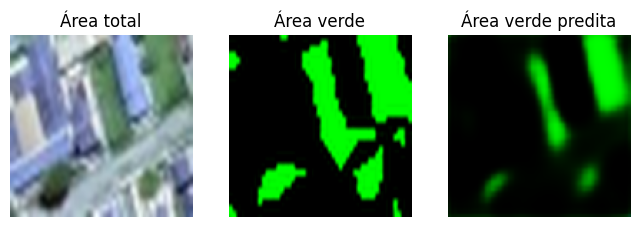

In [64]:
# Obter as imagens redimensionadas e normalizadas
imagem_total = images_test[15]
imagem_verde = labels_test[15]
imagem_predita = predictions[15]

# Plotar as imagens usando Matplotlib
fig, ax = plt.subplots(1, 3, figsize=(8, 5))

# Mostrar a imagem da "Área total"
ax[0].imshow(imagem_total)
ax[0].set_title('Área total')
ax[0].axis('off')

# Mostrar a imagem da "Área verde"
ax[1].imshow(imagem_verde)
ax[1].set_title('Área verde')
ax[1].axis('off')

# Mostrar a imagem da "Área verde"
ax[2].imshow(imagem_predita)
ax[2].set_title('Área verde predita')
ax[2].axis('off')

plt.show()